# EDA Project

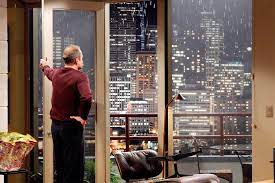

### Introduction to topic and task
The aim of this project is to familiarize with the EDA (Exploratory Data Analysis) part of the Data Science cycle.
For this purpose, several **steps** will be followed
- fetching data from a database
- data cleaning
- Getting an general overview
- explore correlations of data
- plotting different data points and correlations
- coming up with suggestions to the stakeholder

We work on the King County Dataset of houses and sales and we take on the role of a real estate marketer who wants to broker a property to client Larry XYZ.
The client has the following **requirements** for his new home:
- it should be located on the water
- Larry has a limited budget available
- the house should be in a nice condition
- the house should be located rather isolated
- no children should live in the immediate neighborhood, because Larry is afraid of germs
- he himself has some children

During the notebook the following **assumptions** were made
- Larry has at lest 2 children
- a 'nice' condition refers to the objects with a `condition` of 4 or 5
- most people would like to have a bedroom for each of their kids; thus Larry would like to have at least 3 bedrooms (one for his own and one for each of his at least 2 kids). In addition, he wants his neighbors to have as little bedrooms as possible (because than it's more likely, that they don't have any kids)
- a house is isolated, when the distance to the neighbors is high; re, the average size of neighboring plots or/and the size of one's own plot can be used as an indicator

In addition, we will address some **general questions**:
- how does the location at the waterfront influence the price?
- is the number of bedrooms associated with the size of the property?




### Import the needed libraries etc.

In [3]:
import warnings
warnings.filterwarnings("ignore")
# for connection to database
import psycopg2
# for working with dataframes and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import plotly
import plotly.tools as tls
import plotly.graph_objs as go
import vega_datasets
import missingno as msno


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Fetch Data and Store as CSV File

In [ ]:
import os # provides functions for interacting with operating system
from dotenv import load_dotenv # reads key-value pairs from a .env file and can set them as environment variables

load_dotenv() # take environment variables from .env

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

# Create connection object conn
conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

cur = conn.cursor()

sql_query_fetch_all_data = """
    SELECT *
    FROM eda.king_county_house_details
    JOIN eda.king_county_house_sales
    ON eda.king_county_house_details.id = eda.king_county_house_sales.house_id;
"""
cur.execute(sql_query_fetch_all_data)
cur.fetchall()

df_all = pd.read_sql(sql_query_fetch_all_data, conn)
#close the connection
conn.close()
df_all
df_all.to_csv('data/merged_data.csv',index=False)


### Read Dataframe
Because the fetched data was stored to a CSV file , we don't need to fetch it again everytime. When the file `merged_data.csv` in the `data` folder, we can read it using the `pandas.read_csv()` method

### First Exploration of Dataframe

In [5]:
df_houses = pd.read_csv('data/merged_data.csv')

Have a look at the head and tail of the table and explore some general characteristics of the dataframe

In [ ]:
df_houses.head(5)

In [ ]:
df_houses.tail(5)

In [ ]:
df_houses.describe()

In [ ]:
print(df_houses.info())

In [ ]:
df_houses.shape

In [ ]:
df_houses.columns

### Data Cleaning

In [6]:
# remove duplicate column
df_houses = df_houses.drop(columns='house_id')

In [7]:
#rename column id.1
df_houses = df_houses.rename({'id.1':'sale_id'}, axis = 1)

## below not workiung yet!
as long as NaNs in columns, the general type pf the column will remain float!

In [ ]:
def to_int(a):
    '''
    checks if a value a is NA, if not returns int(a)
    '''
    if np.isnan(a):
       return np.NaN
    else:
       return int(a)

In [ ]:
#set all to int
cols = [1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 17, 18, 20]#['bedrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'price']

for col in cols:
    for r in range(len(df_houses)):
        df_houses.iat[r, col] = to_int(df_houses.iat[r, col])
        

### form here on its fine

Correct values in `years` column (devide by 10)

In [8]:
for r in range(len(df_houses['yr_renovated'])):
    if np.isnan(df_houses['yr_renovated'][r]) == False:
        df_houses['yr_renovated'][r] = int((df_houses['yr_renovated'][r])/10) 


### Get an Overview of column content and missing values (NaNs)

In [ ]:
# Check which unique values are present in the columns to identify categorical data
for element in df_houses.columns:
    if df_houses[element].nunique() <= 15:
        print(element, ' : ', df_houses[element].unique())
print('')
print('Columns with many differnet values:')        
for element in df_houses.columns:
    if df_houses[element].nunique() > 15:
        print(element, ' : number of unique values : ', df_houses[element].nunique())

### Get an overview of NaNs in columns

In [ ]:
print(df_houses.isna().sum())
msno.matrix(df_houses)

Because the column `waterfront` is of special interest for our client, we would like to fill in the data gaps. Therefor we can plot the geographical positions on a map to check where they are localized:

In [11]:
import plotly.express as px

In [12]:
waterfront_na = df_houses.query('waterfront != waterfront')
fig = px.scatter_geo(waterfront_na,  locations=,
                     size="pop", # size of markers, "pop" is one of the columns of gapminder
                     )
fig.show()

In [22]:
import geopandas as gpd

In [24]:
gdf = gpd.read_file('king_county_map.topojson')
feature_names = gdf['geometry'].keys()
print(feature_names)

RangeIndex(start=0, stop=0, step=1)


In [28]:
#from vega_datasets import data
states = alt.topo_feature('https://geojson.io/#url-api&map=9.42/47.6077/-122.3838/0/17', feature="collection")

waterfront_na = df_houses.query('waterfront != waterfront')

background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project(from_json('king_county_map.topojson')).properties(
    width=500,
    height=300
)

points = alt.Chart(waterfront_na).mark_circle().encode(
    longitude='long',
    latitude='lat',
    size=alt.value(10),
    tooltip=['id', 'price']
)

background + points

NameError: name 'from_json' is not defined

### Testing for a correlation of number of bedrooms and squarefootage of the object

<Axes: xlabel='bedrooms', ylabel='sqft_living'>

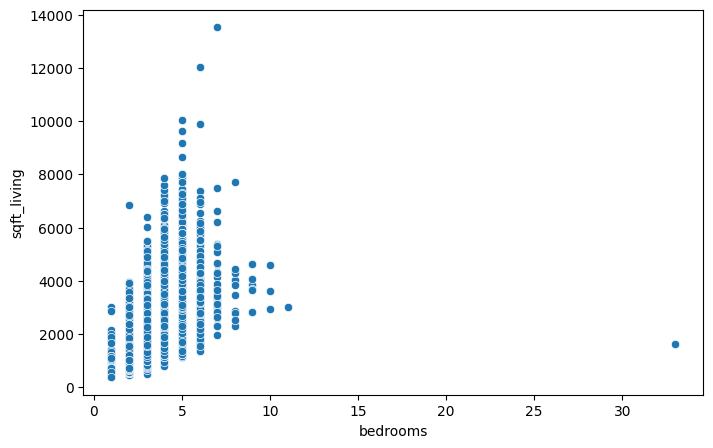

In [29]:
sns.scatterplot(df_houses, x = 'bedrooms', y = 'sqft_living')

In [36]:
df_water1 = df_houses.dropna(subset='waterfront')
df_water = df_water1.query('waterfront == 1')
df_nowater = df_water1.query('waterfront == 0')

The mean price of houses at waterfront:  1717214.73 $
The mean price of houses w/o view of water:  532771.21 $
The average price of houses at waterfront is  3.0 times the price of houses without view of waterfront
The average price per squarefoot at waterfront is approx.  529.23 $/sqft.
The average price per squarefoot at waterfront is  256.91 $/sqft.
The average price per squarefoot of houses at waterfront is approx. 2.0 times the price of houses without view of waterfront


<Axes: xlabel='waterfront', ylabel='price'>

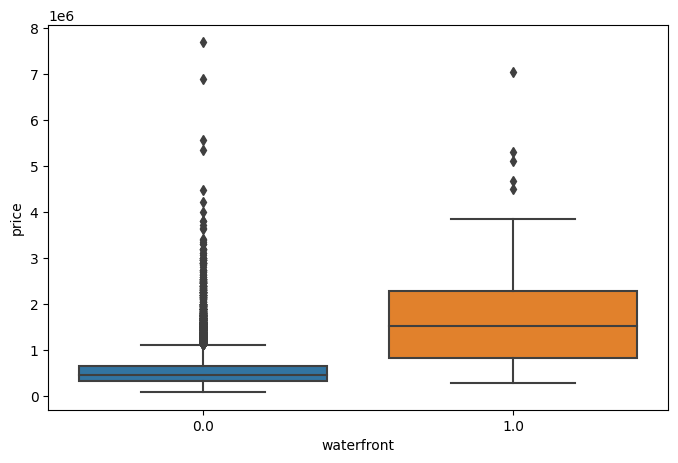

In [59]:
print('The mean price of houses at waterfront: ', df_water1.query('waterfront == 1')['price'].mean().round(2), '$')
print('The mean price of houses w/o view of water: ', df_water1.query('waterfront == 0')['price'].mean().round(2), '$')
print('The average price of houses at waterfront is ', 
      ((df_water1.query('waterfront == 1')['price'].mean())/
       (df_water1.query('waterfront == 0')['price'].mean())).round(), 
       'times the price of houses without view of waterfront'
       )
print('The average price per squarefoot at waterfront is approx. ', 
      (df_water1.query('waterfront == 1')['price'].mean()/
      df_water1.query('waterfront == 1')['sqft_living'].mean()).round(2), '$/sqft.')
print('The average price per squarefoot at waterfront is ', 
      (df_water1.query('waterfront == 0')['price'].mean()/
      df_water1.query('waterfront == 0')['sqft_living'].mean()).round(2), '$/sqft.')

print('The average price per squarefoot of houses at waterfront is approx.',
      ((df_water1.query('waterfront == 1')['price'].mean())/
        (df_water1.query('waterfront == 1')['sqft_living'].mean())/
        ((df_water1.query('waterfront == 0')['price'].mean())/
          (df_water1.query('waterfront == 0')['sqft_living'].mean()))).round(),
'times the price of houses without view of waterfront'
)
sns.boxplot(df_water1, x = 'waterfront', y='price')

In [ ]:
df_water_3br = df_water.query('bedrooms >= 3') #because at least 2 kids
df_water_3br.head()

In [ ]:
df_water_3br['price'].mean().round(2)

In [ ]:
sns.scatterplot(df_houses, x = 'condition', y = 'price')

In [ ]:
df_renovated = df_water = df_houses.dropna(subset='yr_renovated')

df_renovated = df_renovated.query('yr_renovated != 0')

In [ ]:
sns.scatterplot(df_renovated, x = 'condition', y = 'yr_renovated')

In [ ]:
df_water_3br_nice = df_water_3br.query('condition > 3') # because 'nice'

In [ ]:
len(df_water_3br_nice)

In [ ]:
sns.scatterplot(df_water_3br_nice, x = 'sqft_living15', y = 'sqft_lot15')

In [ ]:
df_water_3br_nice['sqft_lot15'].plot(kind = 'box')

In [ ]:
df_water_3br_nice['sqft_living15'].plot(kind = 'box')

In [ ]:
df_water_3br_nice['price'].plot(kind = 'box')

In [ ]:
df_houses['price'].plot(kind = 'box')

In [ ]:
df_all_met_ex_price = df_water_3br_nice.query('sqft_lot15 > 60000 and sqft_living15 < 2500')

In [ ]:
len(df_all_met_ex_price)

In [ ]:
df_all_met_ex_price['price']
# --> 13564

In [ ]:
df_houses.iloc[13564]

In [ ]:
df_water['price'].mean()